In [1]:
%pylab inline
import gc
import pdet
import galsim
import numpy as np
import astropy.io.fits as pyfits
import numpy.lib.recfunctions as rfn

from fpfs import imgutil
from fpfs import simutil
from fpfs import fpfsBase
wDir=os.path.join(os.environ['homeWrk'],'FPFS2','sim')

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
ishear =   1
ngal   =   1
rcut   =   16
ngrid  =   64
beg    =   ngrid//2-rcut
end    =   beg+2*rcut
gsigma =   6.*2.*np.pi/64
beta   =   0.75
noiVar =   8e-2

img    =   simutil.make_basic_sim('basicCenter_psf60','g%d-1111' %ishear,2,ny=ngal,nx=ngal,do_write=False)

# PSF
psfData=   pyfits.getdata(os.path.join(wDir,'galaxy_basic_psf60/psf-60.fits'))
npad   =   (ngrid-psfData.shape[0])//2
psfData1=   np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData1.shape[0]==ngrid
psfData2=  psfData1[beg:end,beg:end]
fpTask0=   fpfsBase.fpfsTask(psfData2,beta=beta)
a0     =   fpTask0.measure(img[beg:end,beg:end])

indX    =   np.arange(32,ngrid,64)
indY    =   np.arange(32,ngrid,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])
b0      =   pdet.get_shear_response_rfft(img,psfData1,gsigma=gsigma,\
            coords=coords,thres=0.)
# Noiseless measurements
out0    =   rfn.merge_arrays([a0,b0],flatten=True,usemask=False)
out0D   =   pdet.peak2det(out0)
out0E   =   pdet.fpfsM2E(out0,out0D,const=1000,noirev=False)
del a0,b0

0.7340361


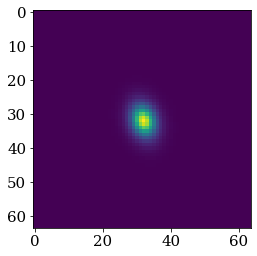

In [3]:
plt.imshow(img)
print(np.max(img))

In [4]:
powIn  =   np.load(os.path.join(wDir,'corPre/noiPows2.npy'),allow_pickle=True).item()['%s'%rcut]*noiVar*100
powModel=  np.zeros((1,powIn.shape[0],powIn.shape[1]))
powModel[0]=powIn
fpTask =   fpfsBase.fpfsTask(psfData2,noiFit=powModel[0],beta=beta,det_gsigma=gsigma)

imgAll=np.tile(img,(100,100))
ngrid2 =   ngrid*100
npad   =   (ngrid2-psfData.shape[0])//2
psfData3=  np.pad(psfData,(npad+1,npad),mode='constant')
assert psfData3.shape[0]==ngrid2

indX    =   np.arange(32,ngrid2,64)
indY    =   np.arange(32,ngrid2,64)
inds    =   np.meshgrid(indY,indX,indexing='ij')
coords  =   np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
coords['pdet_y']=   np.ravel(inds[0])
coords['pdet_x']=   np.ravel(inds[1])

In [5]:
outAll=[]
for ifield in range(50):
    noiFname=   os.path.join(wDir,'noise','noi%04d.fits' %ifield)
    # multiply by 10 since the noise has variance 0.01
    noiData=    pyfits.open(noiFname)[0].data*10.*np.sqrt(noiVar)
    imgTmp =    imgAll+noiData
    # Also times 100 for the noivar model
    # Noisy measurements
    b       =   pdet.get_shear_response_rfft(imgTmp,psfData3,gsigma=gsigma,\
                coords=coords,thres=np.sqrt(noiVar)*0.)
    imgList =   [imgTmp[cc['pdet_y']-rcut:cc['pdet_y']+rcut,\
                cc['pdet_x']-rcut:cc['pdet_x']+rcut] for cc in b]
    a       =   fpTask.measure(imgList)
    out     =   rfn.merge_arrays([a,b],flatten=True,usemask=False)
    outAll.append(out)
    del a,b,imgList,out,imgTmp,noiData 
    gc.collect()

In [6]:
out=    rfn.stack_arrays(outAll,usemask=False)
outD=   pdet.peak2det(out)
outE=   pdet.fpfsM2E(out,outD,const=1000,noirev=True)
outEUC= pdet.fpfsM2E(out,outD,const=1000)
gc.collect()

0

In [7]:
for (j,i) in pdet._default_inds:
    print(j,i)
    print(np.average(outE['fpfs_e1v%d%dr1' %(j,i)]-out0E['fpfs_e1v%d%dr1'%(j,i)]))
    print(np.average(outE['fpfs_e2v%d%dr2' %(j,i)]-out0E['fpfs_e2v%d%dr2'%(j,i)]))

1 2
-5.289804718897044e-05
7.190273191065687e-05
2 1
-0.00014815926180962756
8.478630608097668e-06
2 2
0.00018722149305363487
5.140796834440815e-05
2 3
0.0002511619916272813
-7.594702374218624e-06
3 2
0.00013305000976099673
0.0002247924960936661


In [8]:
for (j,i) in pdet._default_inds:
    print(j,i)
    print(np.average(outEUC['fpfs_e1v%d%dr1'%(j,i)]-out0E['fpfs_e1v%d%dr1'%(j,i)]))
    print(np.average(outEUC['fpfs_e2v%d%dr2'%(j,i)]-out0E['fpfs_e2v%d%dr2'%(j,i)]))

1 2
-0.00011321213494554802
-9.475895981207806e-05
2 1
-0.0003950756957828278
-0.0001358514196576048
2 2
0.0017348386756291534
0.0014759253646358247
2 3
1.2762304299007701e-05
-0.0001548595091967075
3 2
7.502162582055269e-05
6.0307955690470457e-05


In [9]:
print(np.average(outE['fpfs_e1']-out0E['fpfs_e1']))
print(np.average(outE['fpfs_e2']-out0E['fpfs_e2']))

-0.0003274564468920569
0.0004225269490187901


In [10]:
print(np.average(outEUC['fpfs_e1']-out0E['fpfs_e1']))
print(np.average(outEUC['fpfs_e2']-out0E['fpfs_e2']))

0.0011434142559274133
-0.000985617508080019


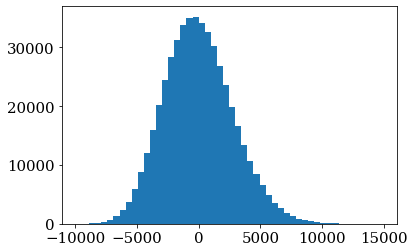

In [11]:
name='fpfs_M00'
_=plt.hist(out[name]-out0[name],bins=50)

In [12]:
name1='fpfs_M00'
name2='fpfs_M00'
name3='fpfs_N00N00'
print(np.average((out[name2]-out0[name2])*(out[name1]-out0[name1])))
print(np.average(out[name3]))

7869570.824337926
9468097.425120182


In [13]:
for ind in pdet._default_inds:
    name1='fpfs_M22c'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N22cV%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))
for ind in pdet._default_inds:
    name1='fpfs_M00'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N00V%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

-1.0794594544960576
-2.1272150336707853
-4.060827745999763
-3.0163025228910745
22.291958012653065
19.156386289197485
-2.59066832400265
-3.016852155086596
0.46879210789526965
-2.126449392947713
5.819102999670458
1.8448136466023366
-1.9537412858212002
-2.0563870681918406
2.7784716637961058
0.7807794642527884
-0.24115290806206113
-2.058575378805801
1.713596032016929
1.8428179691800777


In [14]:
for ind in pdet._default_inds:
    name1='fpfs_M22s'
    name2='pdet_v%d%dr2' %ind
    name3='pdet_N22sV%d%dr2' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

-2.426120270753622
-2.57604038989845
-3.392824588981391
-2.500564493120047
18.401177446312285
18.54167392987647
-2.3158596916712133
-2.5069577905626073
0.10447730970278679
-2.5719287038239895


In [15]:
for ind in pdet._default_inds:
    print(ind)
    name1='fpfs_M00'
    name2='pdet_v%d%dr2' %ind
    name3='pdet_N00V%d%dr2' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

(1, 2)
-3.376467253187833
0.0744721256132871
(2, 1)
3.3537775557749314
0.07019548319588244
(2, 2)
-1.2679943870943728
-0.5208289330142725
(2, 3)
-3.37123624478431
0.07189059515195009
(3, 2)
0.950981507908907
0.07273349728006258


In [16]:
for ind in pdet._default_inds:
    print(ind)
    name1='fpfs_M00'
    name2='pdet_v%d%dr1' %ind
    name3='pdet_N00V%d%dr1' %ind
    print(np.average((outD[name2]-out0D[name2])*(out[name1]-out0[name1])))
    print(np.average(outD[name3]))

(1, 2)
5.819102999670458
1.8448136466023366
(2, 1)
-1.9537412858212002
-2.0563870681918406
(2, 2)
2.7784716637961058
0.7807794642527884
(2, 3)
-0.24115290806206113
-2.058575378805801
(3, 2)
1.713596032016929
1.8428179691800777


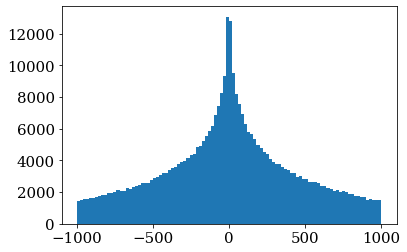

In [17]:
_=plt.hist((outD[name2]-out0D[name2])*(out[name1]-out0[name1]),bins=100,range=(-1000,1000))